# Forward and Backwards Propagation in Convolutional Neural Networks

This is a numerical example which will explain and implement how forward and backward propagation occurs in convolutional neural networks.

First, we will import all the python packages which will be required for a ground-up implementation of these concepts.

## Imports

In [173]:
%load_ext autoreload
%autoreload 2

import itertools

from imageio import imread

from IPython.display import Image, display

from matplotlib import pyplot as plt

import numpy as np

import requests

import cnn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load example data

In the following sections, we will use the following example image:

![](https://img.icons8.com/pastel-glyph/2x/dog--v2.png)

Let's download it.

In [158]:
!curl --silent "https://img.icons8.com/pastel-glyph/2x/dog--v2.png" > data/dog.png
dog = imread("data/dog.png");

We have a (256, 256, 4) image (RGBA) which we will flatten to a (256, 256) grayscale image normalized to the (0, 1) interval:

In [159]:
dog = dog[:, :, 3]
dog = dog - dog.min()
dog = dog / dog.max()
assert dog.shape == (256, 256)
assert dog.min() == 0
assert dog.max() == 1

Let's se if we still have the correct image.

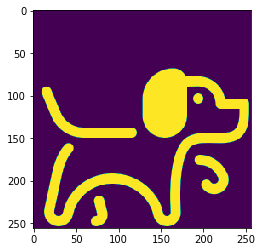

In [160]:
plt.imshow(dog);

## Kernels

One of the first concepts of a CNN model is the so-called _kernel_.
A kernel is a $m \times n$ matrix with a given set of weights.

Let's implement a `Kernel` class for this purpose.

In [163]:
%psource cnn.Kernel.__init__

    def __init__(self, weights: np.ndarray) -> None:
        self.weights = np.array(weights)
        self.shape = self.weights.shape


As you can see, it is simply a `numpy` matrix with a given set of values and a static shape.
Let's instantiate a $3 \times 3$ kernel and plot the visual representation.

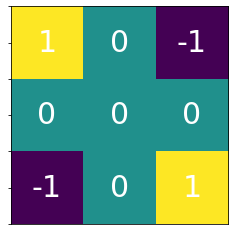

In [164]:
kernel = cnn.Kernel(weights=[[1, 0, -1], [0, 0, 0], [-1, 0, 1]])
kernel.plot()

How should we interpret these weights? The concept of a _kernel_ predates neural networks, and is used in image processing.
In order to discuss this, we should first define and explain the concept of _kernel convolution_.

## Convolution

* Let $w \in \mathcal{R}^{\texttt{KERNEL HEIGHT}~\times~\texttt{KERNEL WIDTH}}$ denote a given kernel.
* Let $a_{x, y} \in \mathcal{R}$ denote image or pooled feature pixel value at index $(x, y)$
    * $x = 1, ..., \texttt{LAYER HEIGHT}$.
    * $y = 1, ..., \texttt{LAYER WIDTH}$.
    
The _convolution operator_, $\circledast$, is then defined as:

\begin{equation*}
    w \circledast a_{x, y} = \sum_{i} \sum_{j} w_{i, j} ~ a_{x - i, y - j}
\end{equation*}

Let's implement this operation:

In [167]:
%psource cnn.Kernel.__mul__

    def __mul__(self, receptive_field: np.ndarray) -> float:
        assert receptive_field.shape == self.shape
        elementwise_multiplication = self.weights * receptive_field
        summarization = elementwise_multiplication.sum()
        return summarization


That's pretty simple. Let us plot an example convolution.

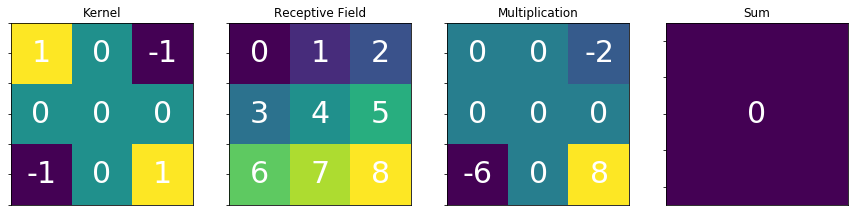

In [168]:
receptive_field = np.arange(0, 9)
receptive_field.shape = (3, 3)
kernel.plot_convolution(receptive_field)

## Moving convolution

Kernel convolution becomes useful for image processing when we move the convolution over the input image.
The convolution will focus on one sub-part of the image at a time, a so-called _receptive field_.
The receptive field must have the same dimensions as the kernel, but we have to decide on how large step sizes we want to take between each convolution. This is called a _stride_.

Let's implement this concept:

In [235]:
%psource cnn.windows

def windows(
    array: np.ndarray,
    window_shape: Tuple[int, int],
    stride: Tuple[int, int],
    apply: Callable[[np.ndarray], Any],
) -> List[List[np.ndarray]]:
    array_height, array_width = array.shape
    stride_height, stride_width = stride
    window_height, window_width = window_shape

    rows = []
    for row in range(0, array_height, stride_height):
        if row + window_height > array_height:
            continue

        cols = []
        for col in range(0, array_width, stride_width):
            if col + window_width > array_width:
                continue

            window = array[
                row:row + window_height,
                col:col + window_width,
            ]
            window = apply(window) if apply else window

            cols.append(window)

        if cols:
            rows.append(cols)

    return np.array(rows)


We can now implement the appliance of a kernel upon an image by convolution over a moving window:

In [234]:
%psource cnn.Kernel.convolute

    def convolute(
        self,
        array: np.ndarray,
        stride: Tuple[int, int],
        padding: int = 0,
    ) -> np.ndarray:
        if padding:
            array = np.pad(array, pad_width=padding)

        return windows(
            array=array,
            window_shape=self.shape,
            stride=stride,
            apply=lambda x: self * x,
        )


Let's take the  following example.

In [195]:
Image(url="https://miro.medium.com/max/1522/1*32zCSTBi3giSApz1oQV-zA.gif", width=500)

Can we replicate the result of this animation?

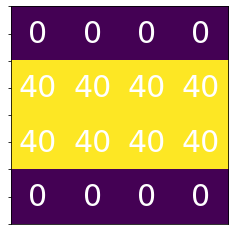

In [233]:
input_ = np.array([
    [10, 10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10, 10],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
])
kernel = cnn.Kernel(
    weights=[
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1],
    ],
)
cnn.plot_matrix(kernel.convolute(input_, stride=(1, 1)))

Yes, it works!

## Kernel interpretation

So how are we supposed to interpret these kernels?
The use of kernel convolutions actually preceeds the invention of CNNs, as they have been used in image processing for quite a long time.

Here are some kernel examples.

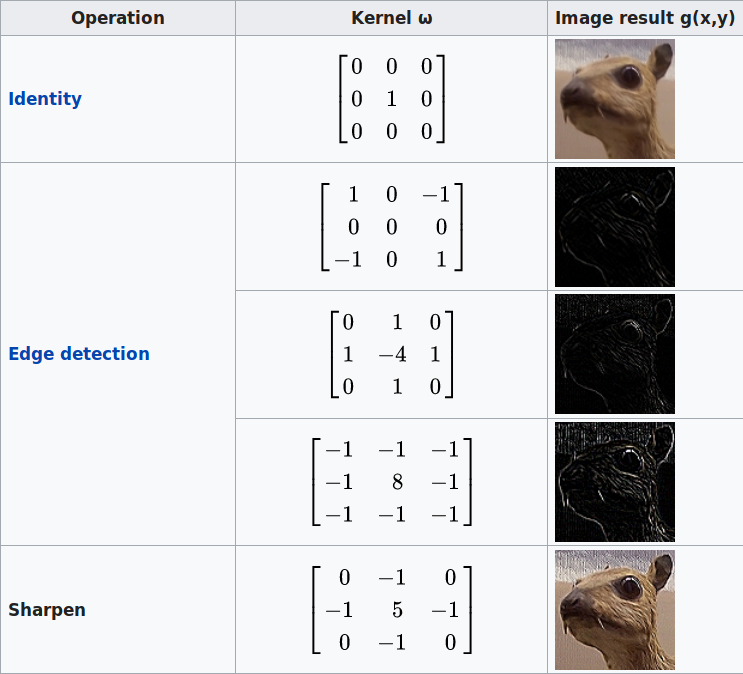

In [201]:
Image("../cnn/img/convolution_kernels_1.png", width=500)

Let's see if we can replicate these results, starting with the identity kernel.

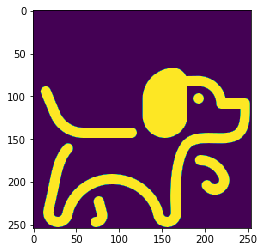

In [209]:
identity_kernel = cnn.Kernel(weights=[[0, 0, 0], [0, 1, 0], [0, 0, 0]])
identity = identity_kernel.convolute(dog, stride=(1, 1))
plt.imshow(identity);

We do indeed have the original image.

What about the edge detection kernel?

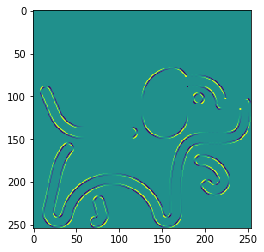

In [236]:
edge_detection_kernel = cnn.Kernel(weights=[[1, 0, -1], [0, 0,  0], [-1, 0, 1]])
edge_detection = edge_detection_kernel.convolute(dog, stride=(1, 1))
plt.imshow(edge_detection);

It is clear that edges have been retrieved from the image.

### Dimension reduction

Kernel convolution can result in reduction of dimensionality.
The first cause for dimension reduction is that the kernel $(n \times m)$ kernel matrix, with $n, m \geq 1$ can't possibly applied to a $N \times M$ image exactly $N \cdot M$ times. The convolution can't be fit into the image that many times.

We can see that this did in fact occur with the identity padding, even when we had `(1, 1)` stride.

In [212]:
print(dog.shape)
print(identity.shape)

(256, 256)
(254, 254)


We will therefore lose information on the edges of the image after having applide the convolution.
The solution to this problem is to pad the image with zeros.

In [213]:
Image(url="https://miro.medium.com/max/1595/1*W2D564Gkad9lj3_6t9I2PA@2x.gif", width=300)

This can be easily implemented with `numpy.pad`.

In [217]:
padded_identity = identity_kernel.convolute(dog, stride=(1, 1), padding=1)
print(dog.shape)
print(padded_identity.shape)

(256, 256)
(256, 256)


We can see that this problem has been rectified with padding.

There are other ways to reduce the dimensionality with convolution.
A $4 \times 4$ kernel with stride $4 \times 4$ will reduce the resolution in both dimensions by four, for instance.
Let's see this in practice.

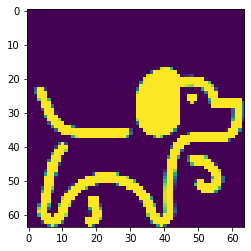

In [225]:
reducing_kernel = cnn.Kernel(weights=[[0, 0, 0, 0], [0, 1, 1, 0], [0, 0, 0, 0]])
reduced = reducing_kernel.convolute(dog, stride=(4, 4), padding=0)
plt.imshow(reduced);

In [226]:
print(dog.shape)
print(reduced.shape)

(256, 256)
(64, 64)


The resulting convolution filter is in fact reduced to one fourth of the original size.

## Pooling Layer

While convolution can in fact reduce the dimensions of the resulting filter, this is _not_ the main purpose of the convolution layer of a CNN.
Small kernel sizes with equal stride sizes (so-called adjacent receptive fields) are often used in practice, resulting in neglible dimension reduction.
The convolutional layer can be thought of a feature extraction algorithm which is automatically tuned for best results during training.

Dimension reduction is still actually preferential, since it increases the robustness of the resulting neural network.

> [...] a reduction in spatial resolution appears to be responsible for achieving translational invariance.

The so-called _pooling layer_ is responsible for dimension reduction, also known as _subsampling_.
The pooling layer is motivated by a model of the mamalian visual cortex, and follows the convolutional layer in most CNNs.

### Max Pooling

There are several types of pooling mechanisms in use, one of the more common ones is _max pooling_.
As with convolution, we define the window size and step size of the _pooling neighbourhood_.
Max pooling simply takes the maxmimum of the values in a given pooling neighbourhood.

Let's implement a `MaxPool` class:

In [227]:
%psource cnn.MaxPool.__init__

    def __init__(
        self,
        shape: Tuple[int, int],
        stride: Tuple[int, int],
    ) -> None:
        self.shape = shape
        self.stride = stride


And then we implement the `pooling` operation itself:

In [230]:
%psource cnn.MaxPool.pool

    def pool(self, array):
        row_windows = windows(
            array=array,
            window_shape=self.shape,
            stride=self.stride,
            apply=lambda x: x.max()
        )
        return np.array(row_windows)


A max pool with shape `(1, 1)` and stride `(1, 1)` is in practice a no-op.
Let's confirm this:

In [239]:
identity_pool = cnn.MaxPool(shape=(1, 1), stride=(1, 1))
(identity_pool.pool(dog) == dog).all()

True

Correct!

What about a max pool layer with shape `(2, 2)` and stride `(2, 2)`?

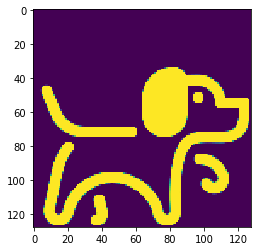

In [247]:
halvation_pool = cnn.MaxPool(shape=(2, 2), stride=(2, 2))
halvation = halvation_pool.pool(dog)
plt.imshow(halvation);

We can see that the resolution has been halved, let's dobbel-check this.

In [248]:
print(dog.shape)
print(halvation.shape)

(256, 256)
(128, 128)


Correct.

Now, let's see if we can replicate the following illustration of a max pool.

![](https://vernlium.github.io/2018/10/15/coursera-deeplearning-ai-c4-week1/maxpool_animation.gif)

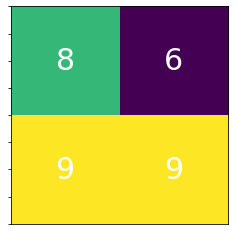

In [251]:
input_ = np.array([
    [7, 3, 5, 2],
    [8, 7, 1, 6],
    [4, 9, 3, 9],
    [0, 8, 4, 5],
])
cnn.plot_matrix(halvation_pool.pool(input_))

We have the same results!

As mentioned previously, in practice a convolution layer is followed up by a pooling layer in most CNNs.
Let's see how these two concepts fit together:;

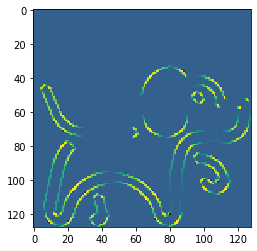

In [262]:
plt.imshow(
    halvation_pool.pool(
        edge_detection_kernel
        .convolute(
            dog,
            stride=(1, 1),
            padding=1
        )
    )
);

What we have neglected to mention here, is that we have implicitly chosen the _identity function_ $f(z) = z$ as the activation function, and forced the bias to be constantly equal to zero.

Both of these concepts need to be implemented in the convolutional layer in order to properly implement a CNN.

## Activation functions

Let's start by implementing the three common activation functions; _identity_, _ReLU_, and _sigmoid_.

In [259]:
%psource cnn.ActivationFunction.identity

    @staticmethod
    def identity(x: np.ndarray) -> np.ndarray:
        return x


In [260]:
%psource cnn.ActivationFunction.relu

    @staticmethod
    def relu(x: np.ndarray) -> np.ndarray:
        return np.maximum(x, 0)


In [261]:
%psource cnn.ActivationFunction.sigmoid

    @staticmethod
    def sigmoid(x: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-x))


We can now take a look at how the activation function affects a total forward pass through the convolutional and pooling layer:

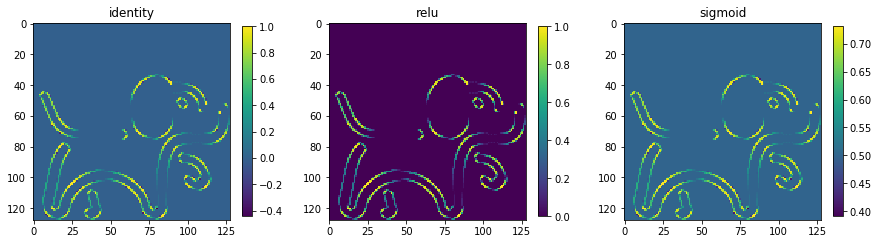

In [294]:
def forward_pass(bias=0):
    activation_functions = [
        cnn.ActivationFunction.identity,
        cnn.ActivationFunction.relu,
        cnn.ActivationFunction.sigmoid,
    ]
    fig, axs = plt.subplots(1, 3, figsize=(15, 7))
    for af, ax in zip(activation_functions, axs):
        image = ax.imshow(
            halvation_pool.pool(
                edge_detection_kernel
                .convolute(
                    dog,
                    stride=(1, 1),
                    padding=1,
                    activation_function=af,
                    bias=bias,
                )
            ),
        )
        ax.set_title(af.__name__)
        plt.colorbar(image, ax=ax, shrink=0.5)
        
forward_pass()

We can see that the _identity_ function has left the convolutional layer as is, _relu_ has removed negative values along the edges, and the sigmoid function has increased most values to the neighbourhood of `0.5`, as $sigmoid(0) = 1/2$.

Let's try to add a bias this time, and see how it affects the result.

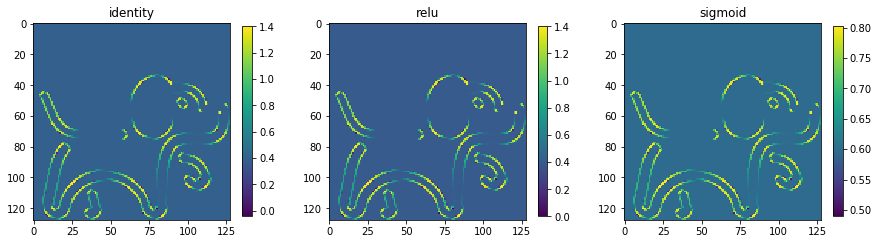

In [297]:
forward_pass(bias=0.4)

Since we added `bias=0.4`, the minimum value of the convolution filter, `identity` has become equar to `ReLU`.

What if we add bias $\approx \infty$?

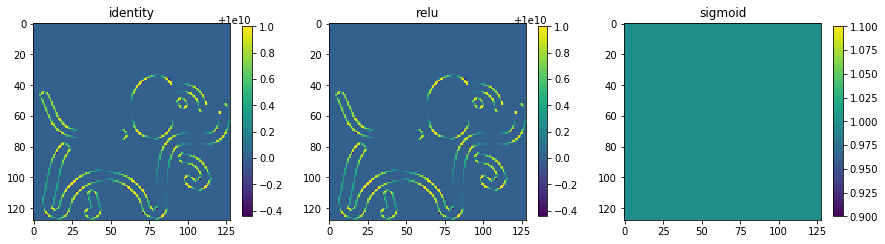

In [299]:
forward_pass(bias=1e10)

Here we see that the sigmoid activation function has been saturated, since $\lim_{x \rightarrow \infty} sigmoid(x) = 1$ and the derivative becomes zero. This phenomena is not observed with the identity and ReLU activation functions.

## Forward pass

A convolutional forward pass can therefore be summarized as.

* Let $l = 1, ..., L_{c}$ index the $L_c$ convolutional layers in the architecture. We then have:

\begin{equation*}
    z_{x,y}^{(l)} = w^{(l)} \circledast a_{x,y}^{(l - 1)} + b^{(l)}
\end{equation*}

* Let $f: \mathcal{R} \rightarrow \mathcal{R}$ be the _activation function_ of choice. We then have:

\begin{equation*}
    a_{x,y}^{(l)} = f ~ \left(z_{x,y}^{(l)}\right)
\end{equation*}

* $a_{x,y}^{(0)} = \{\text{values of pixels in the original input image}\}$.
* $a_{x,y}^{(L_c)} = \{\text{values of pooled features in last layer of the CNN}\}$.

## Backpropagation

We will now explain how to derive the expressions for _backpropagation_

* Let $C$ denote the cost function.
* The error at position $(x, y)$ in the _pooled layer_ number $l$ is then defined as:

\begin{equation*}
    \delta_{x,y}^{(l)} = \frac{\partial C}{\partial z_{x,y}^{(l)}}
\end{equation*}

Let $\mathcal{I}$ and $\mathcal{J}$ be index sets which contain all the indeces of $i$ and $j$ which are involved in the calculation of $z_{x, y}$. Using the chain rule we can relate $\delta_{x,y}^{(l)}$ to $\delta_{x,y}^{(l+1)}$:

\begin{equation*}
    \delta_{x,y}^{(l)}
    =
    \frac{\partial C}{\partial z_{x,y}^{(l)}}
    =
    \sum \limits_{i \in \mathcal{I}} ~ \sum \limits_{j \in \mathcal{J}} ~ 
    \frac{\partial C}{\partial z_{i,j}^{(l+1)}} \frac{\partial z_{i,j}^{(l+1)}}{\partial z_{x,y}^{(l)}}
\end{equation*}

Now insert definition for $\delta_{i,j}^{(l+1)}$:

\begin{equation*}
    ... =
    \sum \limits_{i \in \mathcal{I}} ~ \sum \limits_{j \in \mathcal{J}} ~ 
    \delta_{i,j}^{(l+1)} \frac{\partial}{\partial z_{x,y}^{(l)}} \left[ z_{i,j}^{(l+1)} \right].
\end{equation*}

Write out $z_{i,j}^{(l+1)}$:

\begin{equation*}
    \sum \limits_{i \in \mathcal{I}} ~ \sum \limits_{j \in \mathcal{J}} ~ 
    \delta_{i,j}^{(l+1)} \frac{\partial}{\partial z_{x,y}^{(l)}} \left[ z_{i,j}^{(l+1)} \right]
    =
    \sum \limits_{i \in \mathcal{I}} ~ \sum \limits_{j \in \mathcal{J}} ~ 
    \delta_{i,j}^{(l+1)} \frac{\partial}{\partial z_{x,y}^{(l)}}
        \left[ w^{(l+1)} \circledast a_{i,j}^{(l)} + b^{(l+1)} \right],
\end{equation*}

Write out $a_{i,j}^{(l)}$ and use $\frac{\partial b^{(l+1)}}{\partial z_{x,y}^{(l)}} = 0$:

\begin{equation*}
    ... =
    \sum \limits_{i \in \mathcal{I}} ~ \sum \limits_{j \in \mathcal{J}} ~ 
    \delta_{i,j}^{(l+1)} \frac{\partial}{\partial z_{x,y}^{(l)}}
        \left[ w^{(l+1)} \circledast f~\left(z_{i,j}^{(l)}\right) \right],
\end{equation*}

Write out $w^{(l+1)} \circledast f~\left(z_{i,j}^{(l)}\right)$:

\begin{equation*}
    ... =
    \sum \limits_{i \in \mathcal{I}} ~ \sum \limits_{j \in \mathcal{J}} ~ 
    \delta_{i,j}^{(l+1)} \frac{\partial}{\partial z_{x,y}^{(l)}}
        \left[ \sum \limits_{u} ~ \sum \limits_{v}
        \left( w_{u, v}^{(l+1)} ~ f~\left(z_{i - u, j - v}^{(l)}\right) \right) \right],
\end{equation*}

Nonzero derivatives satisfy: $i - u = x \wedge j - v = y$:

\begin{align*}
    \sum \limits_{i \in \mathcal{I}} ~ \sum \limits_{j \in \mathcal{J}} ~ 
    \delta_{i,j}^{(l+1)} \frac{\partial}{\partial z_{x,y}^{(l)}}
        \left[ \sum \limits_{u} ~ \sum \limits_{v}
        \left( w_{u, v}^{(l+1)} ~ f~\left(z_{i - u, j - v}^{(l)}\right) \right) \right]
    \\
    =
    \sum \limits_{i \in \mathcal{I}} ~ \sum \limits_{j \in \mathcal{J}} ~ 
    \delta_{i,j}^{(l+1)}
        w_{i - x, j - y}^{(l+1)} ~~ f~\prime\left(z_{x, y}^{(l)}\right),
\end{align*}

Put constant derivative outside the sum:

\begin{equation*}
    ... =
    f~\prime\left(z_{x, y}^{(l)}\right)
    \sum \limits_{i \in \mathcal{I}} ~ \sum \limits_{j \in \mathcal{J}} ~ 
    \delta_{i,j}^{(l+1)}
        w_{i - x, j - y}^{(l+1)},
\end{equation*}

Identify the double sum as a convolution of $\delta_{x,y}^{(l+1)}$ over $w_{x,y}$, but flipped over both axes and remembering that $w$ is independent of $(x, y)$:

\begin{equation*}
    ... =
    f~\prime\left(z_{x, y}^{(l)}\right)
    \left[ 
        \delta_{x,y}^{(l+1)}
        \circledast
        \texttt{rot180}\left( w_{x, y}^{(l+1)} \right)
    \right]
    =
    f~\prime\left(z_{x, y}^{(l)}\right)
    \left[ 
        \delta_{x,y}^{(l+1)}
        \circledast
        \texttt{rot180}\left( w^{(l+1)} \right)
    \right]   
\end{equation*}

## Error formula

We now have a formula for $\delta_{x,y}^{(l)}$:

\begin{equation*}
    \delta_{x,y}^{(l)}
    =
    f~\prime\left(z_{x, y}^{(l)}\right)
    \left[ 
        \delta_{x,y}^{(l+1)}
        \circledast
        \texttt{rot180}\left( w^{(l+1)} \right)
    \right]    
\end{equation*}

And we can now derive the derivative of the loss function with respect to the weights.
We begin by using the chain rule:

\begin{equation*}
    \frac{\partial C}{\partial w_{i,j}^{(l)}}
    =
    \sum \limits_{x} \sum \limits_{y}
    \frac{\partial C}{\partial z_{x,y}^{(l)}}
    \frac{\partial z_{x,y}^{(l)}}{\partial w_{i,j}^{(l)}}
\end{equation*}

Replace the definition of $\delta_{x,y}^{(l)}$ and write out $z_{x,y}^{(l)}$:

\begin{equation*}
    ... =
    \sum \limits_{x} \sum \limits_{y}
    \delta_{x,y}^{(l)}
    \frac{\partial}{\partial w_{i,j}^{(l)}} \left[
        \sum \limits_{i} \sum \limits_{j}
        w_{i,j}^{(l)} f~\left(z_{x - i, y - j}^{(l - 1)} \right) + b^{(l)}
    \right]
\end{equation*}

Use the same manipulation as before in order to remove all zero terms caused by the derivative:

\begin{equation*}
    ... =
    \sum \limits_{x} \sum \limits_{y}
    \delta_{x,y}^{(l)} ~ f~\left( z_{x - i, y - l}^{(l - 1)} \right)
    =
    \sum \limits_{x} \sum \limits_{y}
    \delta_{x,y}^{(l)} ~ a_{x - i, y - j}^{(l - 1)}
\end{equation*}

Again we have a convolution of $\delta_{x,y}^{(l)}$ over $\texttt{rot180}\left(a_{x, y}^{(l-1)}\right)$:

\begin{equation*}
    \frac{\partial C}{\partial w_{i,j}^{(l)}}
    =
    \delta_{i,j}^{(l)} \circledast \texttt{rot180}\left(a_{i, j}^{(l-1)}\right)
\end{equation*}

Repeating this logic with $\frac{\partial}{\partial b^{(l)}}$ instead of $\frac{\partial}{\partial w_{i,j^{(l)}}}$ we find that:

\begin{equation*}
    \frac{\partial C}{\partial b^{(l)}} = \sum \limits_{x} \sum \limits_{y} \delta_{x,y}^{(l)}
\end{equation*}

## Gradient Descent Update Equations

With a constant learning rate of $\alpha$ we update the kernel weight at location $(i,j)$ in layer $l$:

\begin{align*}
    w_{i,j}^{(l)} \leftarrow w_{i,j}^{(l)} - \alpha \delta_{i,j}^{(l)} \circledast \texttt{rot180}\left(a_{i, j}^{(l-1)}\right)
\end{align*}

And likewise for the bias:

\begin{align*}
    w^{(l)} \leftarrow b^{(l)} - \alpha \sum \limits_{x} \sum \limits_{y} \delta_{x,y}^{(l)}
\end{align*}

# Appendix

## Source Code

In [3]:
%psource cnn

import itertools
from typing import Any, Callable, List, Tuple

from matplotlib import pyplot as plt

import numpy as np


def plot_matrix(matrix: np.ndarray, ax=None) -> None:
    if not ax:
        _, ax = plt.subplots(1, 1)

    ax.imshow(matrix)
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        right=False,
        labelbottom=False,
        labelleft=False,
    )

    for row, col in itertools.product(
        range(matrix.shape[0]),
        range(matrix.shape[1]),
    ):
        ax.text(
            x=col,
            y=row,
            s=matrix[row, col],
            ha="center",
            va="center",
            color="w",
            size=30,
        )


def windows(
    array: np.ndarray,
    window_shape: Tuple[int, int],
    stride: Tuple[int, int],
    apply: Callable[[np.ndarray], Any],
) -> List[List[np.ndarray]]:
    array_height, array_width = array.shape
    stride_height, stride_width = stride
    windo